In [1]:
import pickle
import numpy as np
import glob
import pickle
import matplotlib
import matplotlib.backends.backend_tkagg
#from mmetro_v7 import Mmetro_Utils
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.stats as stats
import random
import matplotlib.animation as animation
import scipy as scipy

def hanning(M, *varargin):
    m = np.linspace(-(M-1)/2,(M-1)/2,M)  
    Win = 0.5 + 0.5*np.cos(2*np.pi*m/M)
    if len(varargin) > 0:
        N = varargin[0]
        Win = np.broadcast_to(Win,(N,M)).T
    return Win

c=2.98e8

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def get_RP(data, frame_size, N, freq_min, freq_max, nfft=2**8, fs=1e6, bg_sub=True):
    # reshape the data
    data = np.reshape(data, (N, frame_size), order='F')
    # background subtraction
    if bg_sub:
        data = data - data[:,0][:,None]

    # normalization
    for i in range(data.shape[1]):
        data[:,i] = data[:,i] - data[:,i].mean()

    # hanning window used for getting RP
    Win2D = hanning(N, int(frame_size))

    RP = signal.zoom_fft(np.multiply(data, Win2D), fn=[freq_min,freq_max], m=nfft, axis=0, fs=fs)
    return RP

def get_RD(RP, frame_size, nfft):
    WinVel2D = hanning(int(frame_size), nfft)
    WinVel2D = WinVel2D.transpose()

    # getting RD
    RPExt = RP
    RPExt = RPExt - np.mean(RPExt, axis=1)[:,np.newaxis]
    RD = np.fft.fft(np.multiply(RPExt, WinVel2D), n=nfft, axis=1)
    RD = np.fft.fftshift(RD, axes=(1,))
    RD[:,116:140] = 0 # removing middle doppler noise
    return RD
    
# ignoring for now 
# not working
def angle_fft(RP_cube, nfft, d_over_lambda=0.5, window=np.hanning):
    """
    RD_cube : (R, D, N_rx)
    returns
        theta      : (Nfft_ang,) angle grid in radians
        P_ang_cube : (R, D, Nfft_ang) power spectrum
    """
    num_tx = 3 
    R, D, N_rx = RP_cube.shape
    w = window(N_rx)                            # spatial window                        # broadcast
    AoA = np.fft.fftshift(
            np.fft.fft(RP_cube * w, n=nfft, axis=2), axes=2)
    AoA_db = 20.0 * np.log10(np.abs(AoA) + 1e-12)
    AoA_norm = AoA_db - AoA_db.max()
    AoA_norm[AoA_norm < -25.0] = -25.0
    AoA_norm = AoA_norm.max(axis=1)
    # # P = np.abs(AoA) ** 2

    # u = (np.arange(nfft) - nfft/2) / nfft
    # theta = np.arcsin(u / d_over_lambda)        # radians
    # WinAnt2D = hanning(int(N_rx), nfft)
    # # sca_win_ant = WinAnt2D.sum()
    # WinAnt2D = WinAnt2D.transpose()
    # j_opt = np.fft.fftshift(np.fft.fft(RP_cube * WinAnt2D, n=nfft, axis=2) / sca_win_ant, axes=2)
    # j_db = 20.0 * np.log10(np.abs(j_opt) + 1e-12)
    # j_norm = j_db - j_db.max()
    # j_norm[j_norm < -25.0] = -25.0
    # j_norm = j_norm.max(axis=1)  # collapse chirp dimension
    return AoA_norm

# Template matching for sinc pattern in RD 
def generate_template(period, frame_size, f_tag, nfft=2**8, tag_duty_cycle=0.5):
    # period = Tc (chrip time)
    # frame size = Nc (#chirps in a frame)
    # nfft = 256 = Ns (number of samples, also the number of points in the FFT)

    # generating a time vector with values for each chirp (period)
    t = np.arange(0, period*frame_size, period)

    # generating a square wave during that time with the given duty cycle 
    sq_wav = signal.square(2*np.pi*f_tag*t, tag_duty_cycle)

    # the template is the FFT of the square wave
    sq_wav_fft = np.fft.fftshift(np.fft.fft(sq_wav, n=nfft, axis=0))
    return sq_wav_fft


def get_range(frame_idx, data_raw, antenna_pick, frame_size, N, chirp_slope, period, range_min, range_max, f_tag, fs=1e6, nfft=2**8):
    data_single_chn = data_raw[:,:,antenna_pick] # select one channel (antena)
    data_snapshot = data_single_chn[:,frame_idx] # select the frame

    # define frequency max and min
    freq_min = 2*range_min * chirp_slope / c
    freq_max = 2*range_max * chirp_slope / c
    
    # get the range profile 
    RP = get_RP(data=data_snapshot, \
                frame_size=frame_size, 
                N=N, 
                freq_min=freq_min, 
                freq_max=freq_max, 
                nfft=nfft,
                fs=fs,
                bg_sub=True)

    # get the range-doppler
    RD = get_RD(RP, frame_size=frame_size, nfft=nfft)

    # Template matching code
    # 400 is the number of frequency steps 
    csweep = np.zeros(400)
    corr_240 = 0
    corr_332 = 0
    for fstep in range(0,400):
        # generate the template for fstep'th frequency step 
        template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=fstep)

        # bunch of stuff happening here, but basically applying the template (currently (N,)) through the entire range axis and then taking dot product with the RD
        # template[:, np.newaxis]                                  --> changes shape from (N,) to (N,1)
        # np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1) --> copies the template in all the range bins 
        correlation = np.sum(np.abs(RD) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1)
        
        # stores the max value for that frequency 
        csweep[fstep] = np.max(correlation)
    
    # Trying to locate the tag -- get indexes for the tags
    # --- why 4 faces? Top face and face D share the same control signal 
    # f_tags = [183, 337, 250, 127]
    f_tags = [156, 250 , 313, 625]
    max_idxs = np.zeros(4)
    for i in range(len(f_tags)):
        # generate the template for that particular tag face
        template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])
        correlation = np.sum(np.abs(RD) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

        # -- why are we calculating this in the loop? 
        freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
        range_steps = freq_steps * c / 2 / chirp_slope

        # get the range index of the highest correlation
        max_idxs[i] = np.argmax(correlation)
    return RP, RD, csweep, max_idxs, range_steps

# not working
def get_angle(frame_idx, data_raw, frame_size, N, chirp_slope, period, range_min, range_max, f_tag, fs=1e6, nfft=2**8):
    # data_snapshot = data_raw[:, frame_idx, :]      # (N, N_rx)
    # N_rx = data_snapshot.shape[1]
    # define frequency max and min
    freq_min = 2*range_min * chirp_slope / c
    freq_max = 2*range_max * chirp_slope / c
    # print(freq_min)
    # print(freq_max)
    v_range = np.arange(nfft) / nfft * fs * c / (2 * chirp_slope)
    r_max_idx = np.argmin(np.abs(v_range - range_max))
    v_range_ext = v_range[: r_max_idx + 1]
    r_offset = np.sum(v_range_ext < 0.1)

    RP = np.empty((nfft,nfft, 4), dtype=complex)
    RD = np.empty((nfft,nfft, 4), dtype=complex)
    for ant in range(4):
        data_single_chn = data_raw[:,:,ant] # select one channel (antena)
        data_snapshot = data_single_chn[:,frame_idx] # select the frame
        RPExt = get_RP(data=data_snapshot,
            frame_size=frame_size, 
            N=N, 
            freq_min=freq_min, 
            freq_max=freq_max, 
            nfft=nfft,
            fs=fs,
            bg_sub=True)
        
        RP[:,:,ant] = RPExt #- np.mean(RPExt, axis=1)[:,np.newaxis]
        # RPExt = RPExt - np.mean(RPExt, axis=1)[:,np.newaxis]
        # RP[:,:,ant] = RPExt[r_offset : r_max_idx + 2,:]
        # RD_temp = get_RD(RPExt, frame_size, nfft)
        # RD[:, :, ant] = RD_temp
    # RD = np.empty((RP.shape[0], nfft, 4), dtype=complex)

    AoA = angle_fft(RP, nfft=nfft)
    # freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    # range_steps = freq_steps * c / 2 / chirp_slope
    return AoA # theta_grid, P_ang, range_steps
        
def plot_rp_rd(file, frame, H_V=False):

    if H_V:
        data_raw_V = pickle.load(open(f"./data/{file}_V-24GHz.pickle", 'rb'))
        data_raw_H = pickle.load(open(f"./data/{file}_H-24GHz.pickle", 'rb'))
    else: 
        data_raw_H = pickle.load(open(f"/nas-data/soham/drone-landing/{file}-24GHz.pickle", 'rb'))

    antenna_pick = 1
    nfft = 2**8
    fs = 1e6
    c = 2.98e8
    range_min = 0
    range_max = 5
    dop_spacing = 2         # Hz, from music code
    doppler_min = 0 
    doppler_max = (8.69*255)/2       # don't know why I'm using them -- from MUSIC code  

    # -- is f_tag the switching frequency? 
    f_tag = 500

    cfg = data_raw_H['Cfg']
    frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
    N = cfg['N']  # Num samples per chirp
    chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
    period = cfg['Perd']

    if H_V:
        data_signal_raw_V = data_raw_V['Data']
    data_signal_raw_H = data_raw_H['Data']

    n_frames = 50

    # -- what's dopwidth? 
    dopwidth = 80
    grid1 = np.zeros((dopwidth, n_frames))
    grid2 = np.zeros((dopwidth, n_frames))
    dopgrid = np.zeros((nfft,n_frames))

    # Initialize plot
    # fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize=(14, 9))
    cbar_rp = None
    cbar_rd = None
    if H_V:
        fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize = (10, 15))
    else:
        fig, ((ax1, ax2), (ax5, ax6)) = plt.subplots(2,2, figsize = (10, 10))
    
    plt.subplots_adjust(hspace= 0.5, wspace = 0.25)
    
    if H_V:
    # Compute V
        RP_V, RD_V, csweep, max_idxs_V, range_steps_V = get_range(
            frame_idx=frame,
            data_raw=data_signal_raw_V,
            antenna_pick=antenna_pick,
            frame_size=frame_size,
            N=N,
            chirp_slope=chirp_slope,
            period=period,
            range_min=range_min,
            range_max=range_max,
            f_tag=f_tag,
            fs=fs,
            nfft=nfft
        )
        max_idx_V = int(max_idxs_V[0])

    # Compute H
    RP_H, RD_H, csweep, max_idxs_H, range_steps_H = get_range(
        frame_idx=frame,
        data_raw=data_signal_raw_H,
        antenna_pick=antenna_pick,
        frame_size=frame_size,
        N=N,
        chirp_slope=chirp_slope,
        period=period,
        range_min=range_min,
        range_max=range_max,
        f_tag=f_tag,
        fs=fs,
        nfft=nfft
    )
    max_idx_H = int(max_idxs_H[0])

    # Clear axes
    if H_V:
        for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
            ax.clear()
    else:
        for ax in (ax1, ax2, ax5, ax6):
            ax.clear()
    
    # ----- SHARED NORMALIZATION -----
    # Range Profiles: same vmin/vmax for V and H
    if H_V: 
        RP_V_abs = np.abs(RP_V)
    RP_H_abs = np.abs(RP_H)
    if H_V:
        vmin_rp = min(RP_V_abs.min(), RP_H_abs.min())
        vmax_rp = max(RP_V_abs.max(), RP_H_abs.max())
    else:
        vmin_rp = RP_H_abs.min()
        vmax_rp = RP_H_abs.max()
    
    norm_rp = matplotlib.colors.Normalize(vmin=vmin_rp, vmax=vmax_rp)

    # Range-Doppler: same vmin/vmax for V and H
    # (you can switch to dB if you prefer: 20*log10(|RD|+eps))
    if H_V:
        RD_V_abs = np.abs(RD_V)
    RD_H_abs = np.abs(RD_H)
    if H_V:
        vmin_rd = min(RD_V_abs.min(), RD_H_abs.min())
        vmax_rd = max(RD_V_abs.max(), RD_H_abs.max())
    else:
        vmin_rd = RD_H_abs.min()
        vmax_rd = RD_H_abs.max()
    
    norm_rd = matplotlib.colors.Normalize(vmin=vmin_rd, vmax=vmax_rd)

    # ----- PLOT -----
    ax1.set_title(f"Range Profile (H)\nMax Index: {max_idx_H}")
    ax1.set_xlabel("Chirp")
    ax1.set_ylabel("Range (m)")
    im_rp_h = ax1.imshow(
        RP_H_abs,
        extent=[0, 255, range_max, range_min],
        aspect=256 / (range_max - range_min),
        norm=norm_rp
    )

    if H_V:
        ax3.set_title(f"Range Profile (V)\nMax Index: {max_idx_V}")
        ax3.set_xlabel("Chirp")
        ax3.set_ylabel("Range (m)")
        im_rp_v = ax3.imshow(
            RP_V_abs,
            extent=[0, 255, range_max, range_min],
            aspect=256 / (range_max - range_min),
            norm=norm_rp  # <-- shared with ax1
        )

    ax2.set_title(f"Range-Doppler (H); Frame {frame}")
    ax2.set_ylabel("Range (m)")
    ax2.set_xlabel("Doppler frequency (Hz)")
    im_rd_h = ax2.imshow(
        RD_H_abs,
        extent=[-doppler_max, doppler_max, range_max, range_min],
        aspect= 2*doppler_max / (range_max - range_min),
        norm=norm_rd
    )

    if H_V:
        ax4.set_title(f"Range-Doppler (V); Frame {frame}")
        ax4.set_ylabel("Range (m)")
        ax4.set_xlabel("Doppler frequency (Hz)")
        im_rd_v = ax4.imshow(
            RD_V_abs,
            extent=[-doppler_max, doppler_max, range_max, range_min],
            aspect=2*doppler_max / (range_max - range_min),
            norm=norm_rd  # <-- shared with ax2
        )

    ax5.plot(np.linspace(-doppler_max, doppler_max, 256), np.abs(RD_H[max_idx_H]))
    ax5.set_xticks(np.linspace(-doppler_max, doppler_max, 8))
    ax5.set_title(f"Slice at range index {max_idx_H}")
    ax5.set_ylabel("np.abs( . )")
    ax5.set_xlabel("Doppler frequency (Hz)")
    peaks, _ = scipy.signal.find_peaks(np.abs(RD_H[max_idx_H]))
    freq_peaks = ((peaks-128)/128)*doppler_max
    print(freq_peaks)

    if H_V:
        ax6.plot(np.linspace(-doppler_max, doppler_max, 256), np.abs(RD_V[max_idx_V]))
        ax6.set_xticks(np.linspace(-doppler_max, doppler_max, 8))
        ax6.set_title(f"Slice at range index {max_idx_V}")
        ax6.set_xlabel("np.abs( . )")
        ax6.set_ylabel("Doppler frequency (Hz)")
        # peaks, _ = scipy.signal.find_peaks(np.abs(RD_V[max_idx_V]))
        # freq_peaks = ((peaks-128)/128)*doppler_max
        # print(freq_peaks)


    # ----- COLORBARS (one per pair), remove old ones if animating -----
    if cbar_rp is not None:
        cbar_rp.remove()
    if cbar_rd is not None:
        cbar_rd.remove()

    # One colorbar for both RPs
    if H_V: 
        cbar_rp = fig.colorbar(im_rp_h, ax=[ax1, ax3], fraction=0.046, pad=0.04)
    else:
        cbar_rp = fig.colorbar(im_rp_h, ax=[ax1], fraction=0.046, pad=0.04)
    cbar_rp.set_label("RP intensity (|·|)")

    # One colorbar for both RDs
    if H_V:
        cbar_rd = fig.colorbar(im_rd_h, ax=[ax2, ax4], fraction=0.046, pad=0.04)
    else:
        cbar_rd = fig.colorbar(im_rd_h, ax=[ax2], fraction=0.046, pad=0.04)
    cbar_rd.set_label("RD intensity (|·|)")

    fig.suptitle(f"{file} H and V")
    

[-1090.66289062 -1064.69472656 -1038.7265625  -1004.10234375
  -969.478125    -934.85390625  -882.91757812  -865.60546875
  -848.29335937  -830.98125     -813.66914062  -779.04492187
  -744.42070312  -718.45253906  -692.484375    -666.51621094
  -623.2359375   -597.26777344  -571.29960937  -545.33144531
  -502.05117187  -467.42695312  -450.11484375  -432.80273437
  -389.52246094  -363.55429687  -346.2421875   -320.27402344
  -285.64980469  -251.02558594  -216.40136719  -199.08925781
  -164.46503906  -112.52871094   103.87265625   121.18476562
   155.80898437   207.7453125    251.02558594   302.96191406
   337.58613281   380.86640625   406.83457031   432.80273437
   467.42695312   519.36328125   545.33144531   571.29960937
   588.61171875   623.2359375    649.20410156   683.82832031
   718.45253906   744.42070312   779.04492187   830.98125
   848.29335937   874.26152344   900.2296875    926.19785156
   943.50996094   986.79023437  1030.07050781  1056.03867187
  1090.66289062]


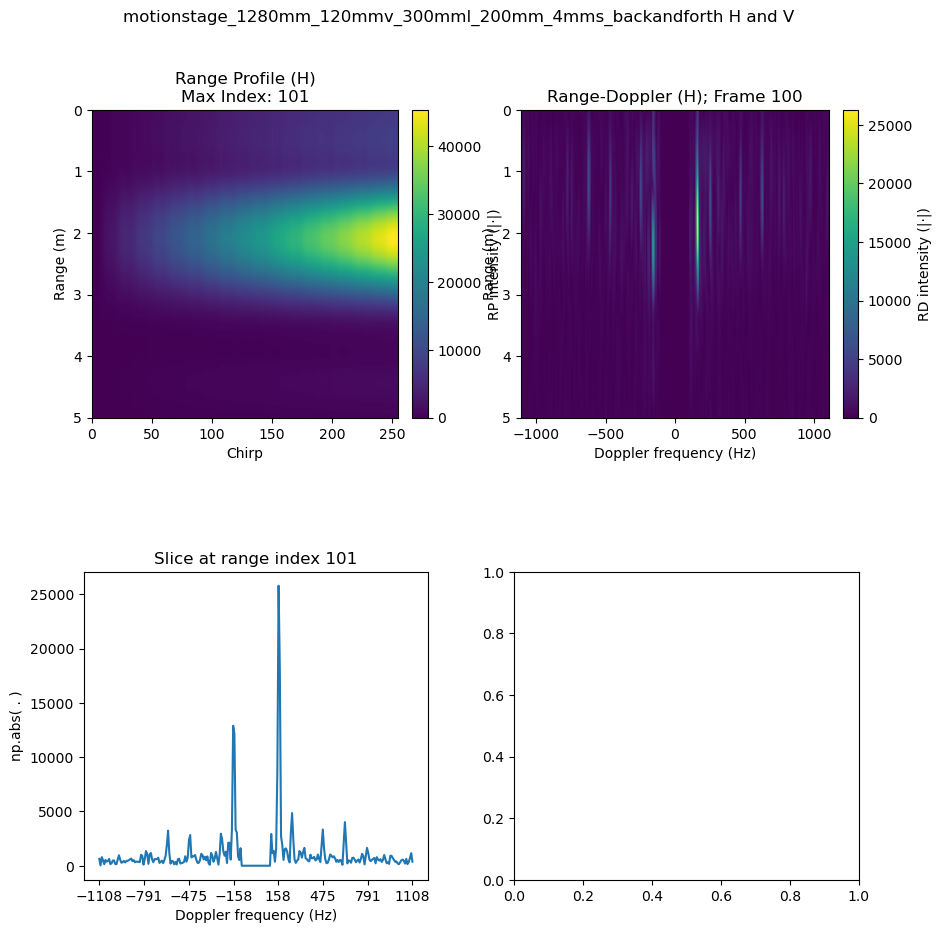

In [2]:
plot_rp_rd("motionstage_1280mm_120mmv_300mml_200mm_4mms_backandforth", 100)

[-1099.31894531 -1073.35078125 -1056.03867187 -1038.7265625
 -1012.75839844  -986.79023437  -960.82207031  -943.50996094
  -917.54179687  -882.91757812  -865.60546875  -848.29335937
  -822.32519531  -805.01308594  -779.04492187  -735.76464844
  -709.79648437  -675.17226562  -640.54804687  -623.2359375
  -588.61171875  -553.9875      -536.67539062  -493.39511719
  -467.42695312  -441.45878906  -415.490625    -372.21035156
  -354.89824219  -320.27402344  -276.99375     -251.02558594
  -216.40136719  -155.80898437  -121.18476562   103.87265625
   155.80898437   181.77714844   199.08925781   225.05742187
   251.02558594   294.30585937   311.61796875   346.2421875
   380.86640625   406.83457031   450.11484375   476.08300781
   510.70722656   562.64355469   597.26777344   623.2359375
   649.20410156   683.82832031   701.14042969   727.10859375
   753.07675781   779.04492187   796.35703125   830.98125
   882.91757812   926.19785156   952.16601562   986.79023437
  1030.07050781  1064.69472656]

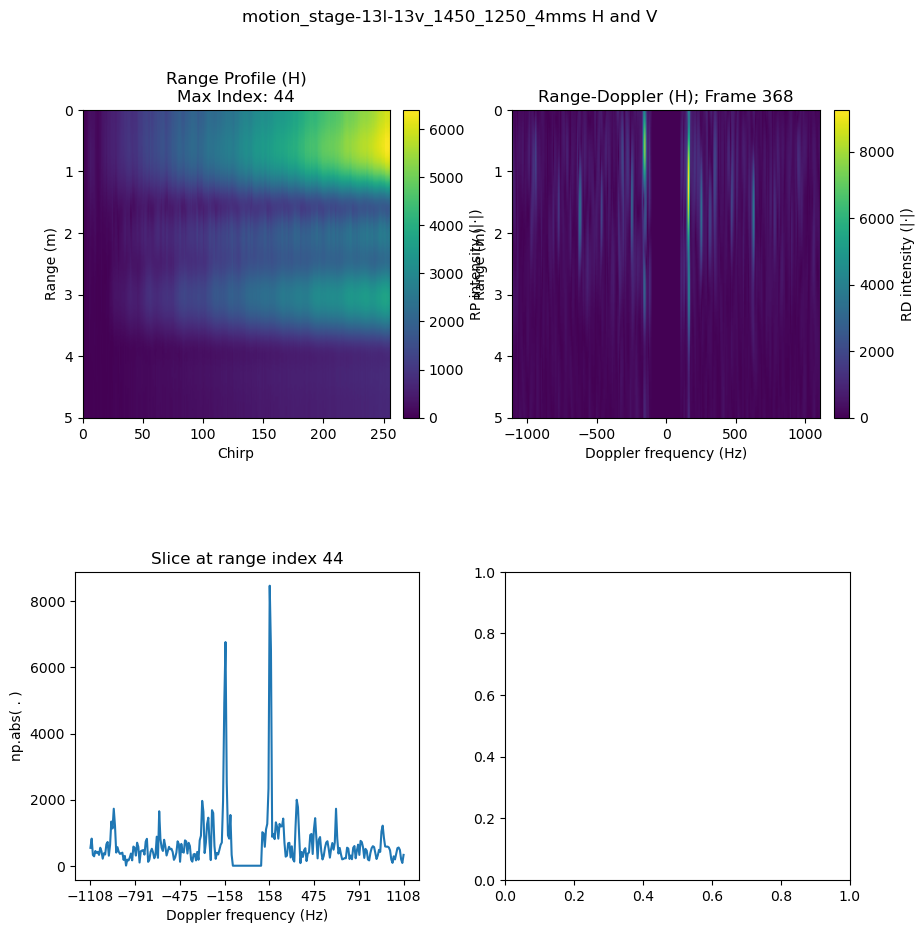

In [6]:
plot_rp_rd("motion_stage-13l-13v_1450_1250_4mms", 368)

[-1090.66289062 -1056.03867187 -1021.41445312 -1004.10234375
  -969.478125    -934.85390625  -917.54179687  -900.2296875
  -848.29335937  -813.66914062  -779.04492187  -753.07675781
  -727.10859375  -692.484375    -657.86015625  -623.2359375
  -597.26777344  -571.29960937  -545.33144531  -502.05117187
  -467.42695312  -415.490625    -389.52246094  -346.2421875
  -311.61796875  -276.99375     -251.02558594  -216.40136719
  -190.43320312  -155.80898437  -121.18476562   103.87265625
   129.84082031   155.80898437   190.43320312   251.02558594
   276.99375      311.61796875   346.2421875    380.86640625
   406.83457031   432.80273437   467.42695312   502.05117187
   528.01933594   553.9875       623.2359375    666.51621094
   692.484375     718.45253906   744.42070312   779.04492187
   813.66914062   848.29335937   891.57363281   908.88574219
   934.85390625   952.16601562   969.478125     995.44628906
  1056.03867187  1090.66289062]


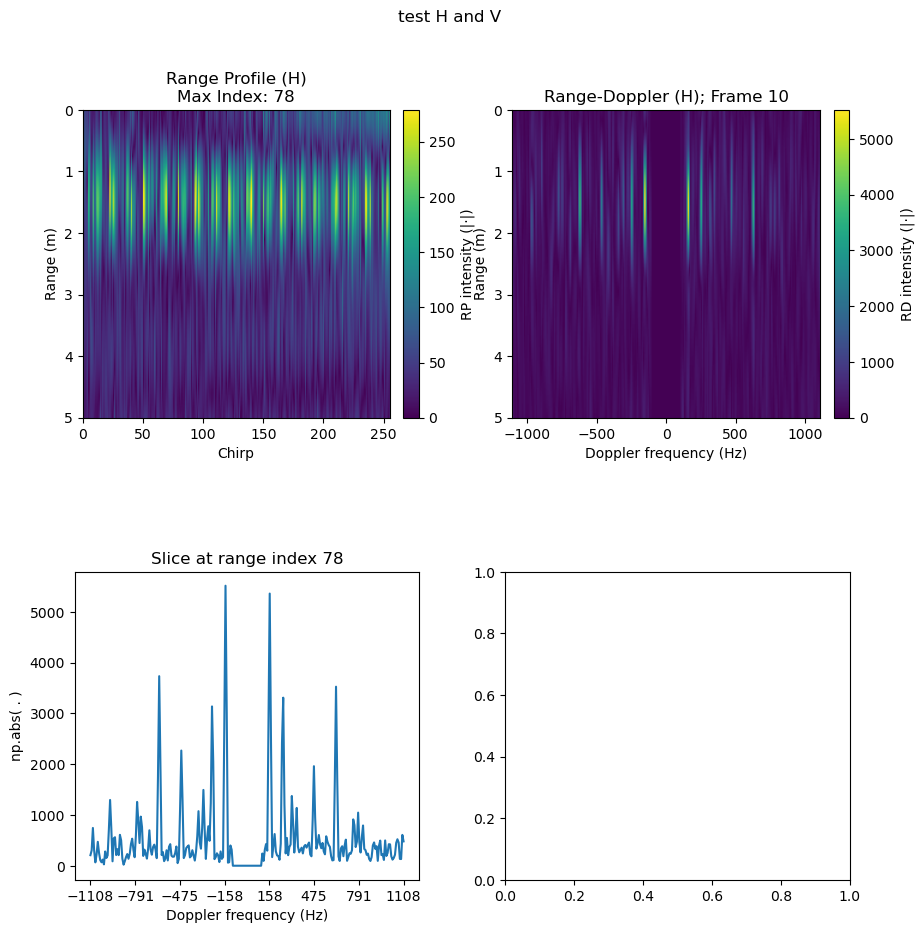

In [2]:
plot_rp_rd("test", 10)

[-1090.66289062 -1056.03867187 -1038.7265625   -995.44628906
  -969.478125    -934.85390625  -900.2296875   -874.26152344
  -830.98125     -779.04492187  -744.42070312  -692.484375
  -657.86015625  -623.2359375   -588.61171875  -553.9875
  -502.05117187  -467.42695312  -415.490625    -380.86640625
  -346.2421875   -311.61796875  -276.99375     -251.02558594
  -207.7453125   -190.43320312  -155.80898437  -121.18476562
   155.80898437   190.43320312   216.40136719   251.02558594
   276.99375      311.61796875   346.2421875    380.86640625
   415.490625     467.42695312   502.05117187   553.9875
   588.61171875   623.2359375    657.86015625   692.484375
   744.42070312   779.04492187   813.66914062   830.98125
   865.60546875   900.2296875    934.85390625   969.478125
  1004.10234375  1038.7265625   1064.69472656  1090.66289062]


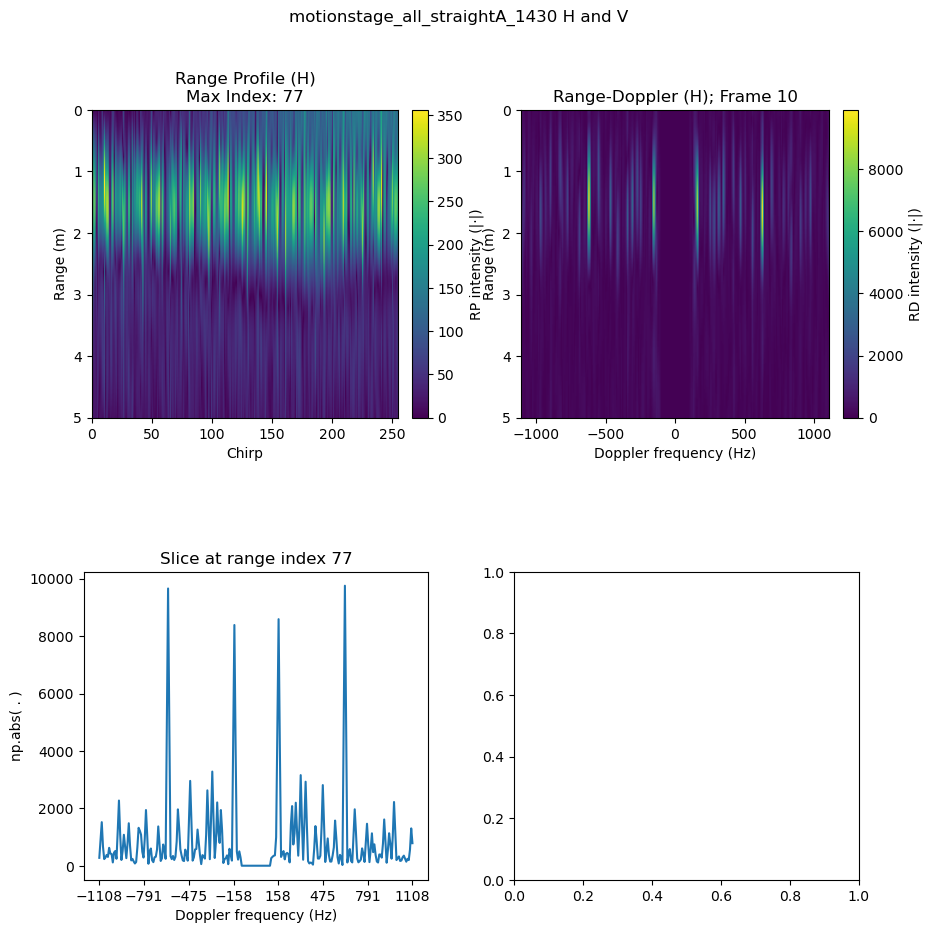

In [3]:
plot_rp_rd("motionstage_all_straightA_1430", 10)

[-1090.66289062 -1064.69472656 -1038.7265625  -1021.41445312
  -986.79023437  -960.82207031  -917.54179687  -882.91757812
  -848.29335937  -813.66914062  -779.04492187  -744.42070312
  -709.79648437  -666.51621094  -623.2359375   -588.61171875
  -571.29960937  -536.67539062  -502.05117187  -467.42695312
  -432.80273437  -406.83457031  -380.86640625  -346.2421875
  -328.93007812  -285.64980469  -251.02558594  -225.05742187
  -190.43320312  -155.80898437  -121.18476562   121.18476562
   155.80898437   190.43320312   233.71347656   268.33769531
   294.30585937   328.93007812   372.21035156   432.80273437
   467.42695312   502.05117187   528.01933594   579.95566406
   605.92382812   640.54804687   666.51621094   709.79648437
   744.42070312   779.04492187   813.66914062   848.29335937
   882.91757812   908.88574219   926.19785156   960.82207031
  1004.10234375  1056.03867187  1090.66289062]


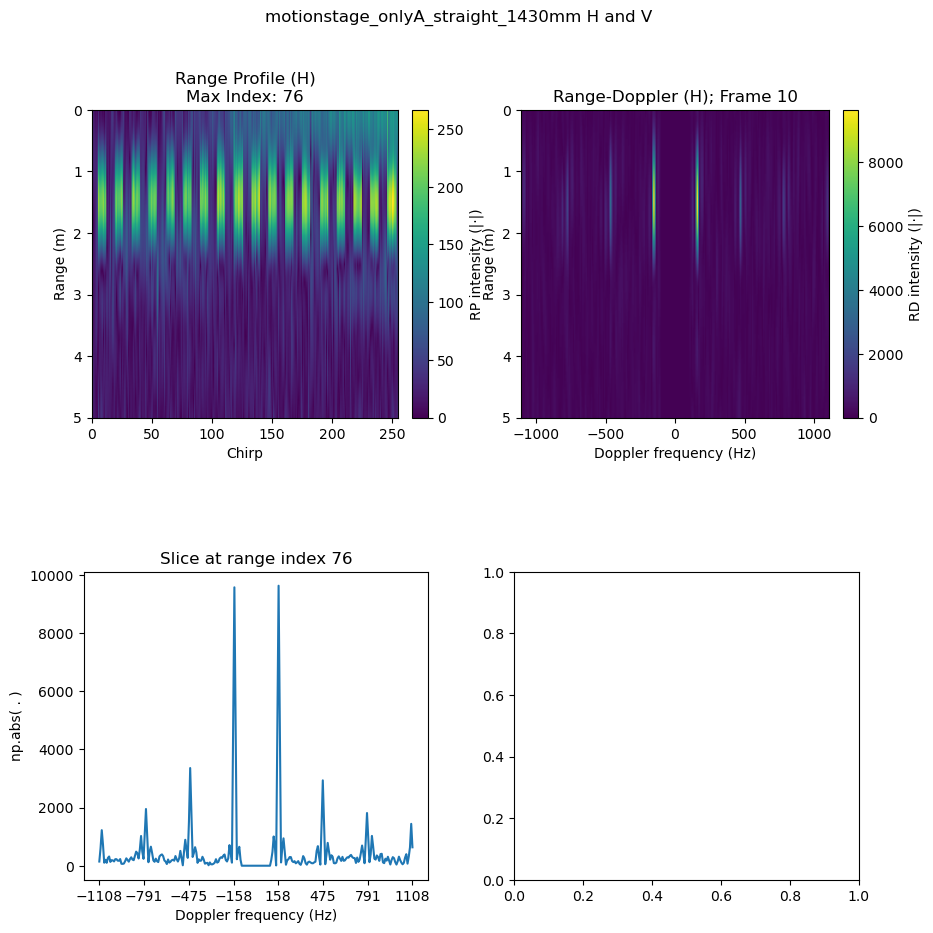

In [2]:
plot_rp_rd("motionstage_onlyA_straight_1430mm", 10)

[-1090.66289062 -1056.03867187 -1021.41445312  -995.44628906
  -952.16601562  -926.19785156  -900.2296875   -874.26152344
  -839.63730469  -813.66914062  -779.04492187  -744.42070312
  -727.10859375  -701.14042969  -666.51621094  -623.2359375
  -588.61171875  -562.64355469  -536.67539062  -502.05117187
  -467.42695312  -432.80273437  -398.17851562  -346.2421875
  -302.96191406  -268.33769531  -225.05742187  -181.77714844
  -155.80898437  -112.52871094   103.87265625   121.18476562
   155.80898437   190.43320312   216.40136719   233.71347656
   251.02558594   276.99375      311.61796875   354.89824219
   380.86640625   432.80273437   467.42695312   502.05117187
   536.67539062   571.29960937   605.92382812   640.54804687
   657.86015625   683.82832031   718.45253906   744.42070312
   779.04492187   813.66914062   848.29335937   874.26152344
   917.54179687   952.16601562   978.13417969   995.44628906
  1021.41445312  1056.03867187  1090.66289062]


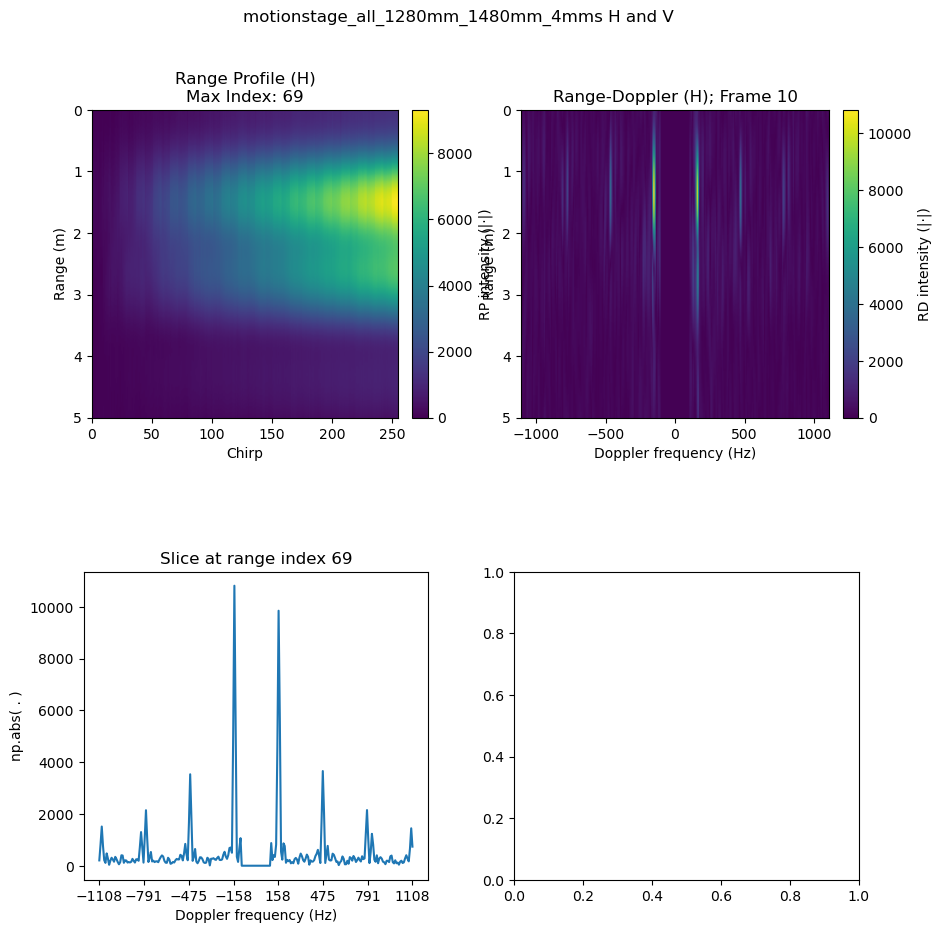

In [5]:
plot_rp_rd("motionstage_all_1280mm_1480mm_4mms", 10)

[-1090.66289062 -1056.03867187 -1021.41445312  -986.79023437
  -952.16601562  -926.19785156  -891.57363281  -848.29335937
  -813.66914062  -779.04492187  -744.42070312  -709.79648437
  -692.484375    -675.17226562  -657.86015625  -631.89199219
  -588.61171875  -536.67539062  -502.05117187  -467.42695312
  -432.80273437  -389.52246094  -337.58613281  -311.61796875
  -285.64980469  -259.68164062  -216.40136719  -190.43320312
  -155.80898437  -129.84082031   121.18476562   155.80898437
   190.43320312   233.71347656   251.02558594   276.99375
   302.96191406   354.89824219   398.17851562   432.80273437
   467.42695312   502.05117187   536.67539062   562.64355469
   588.61171875   605.92382812   623.2359375    640.54804687
   657.86015625   675.17226562   709.79648437   727.10859375
   744.42070312   779.04492187   813.66914062   848.29335937
   900.2296875    917.54179687   943.50996094   969.478125
  1021.41445312  1056.03867187  1090.66289062]


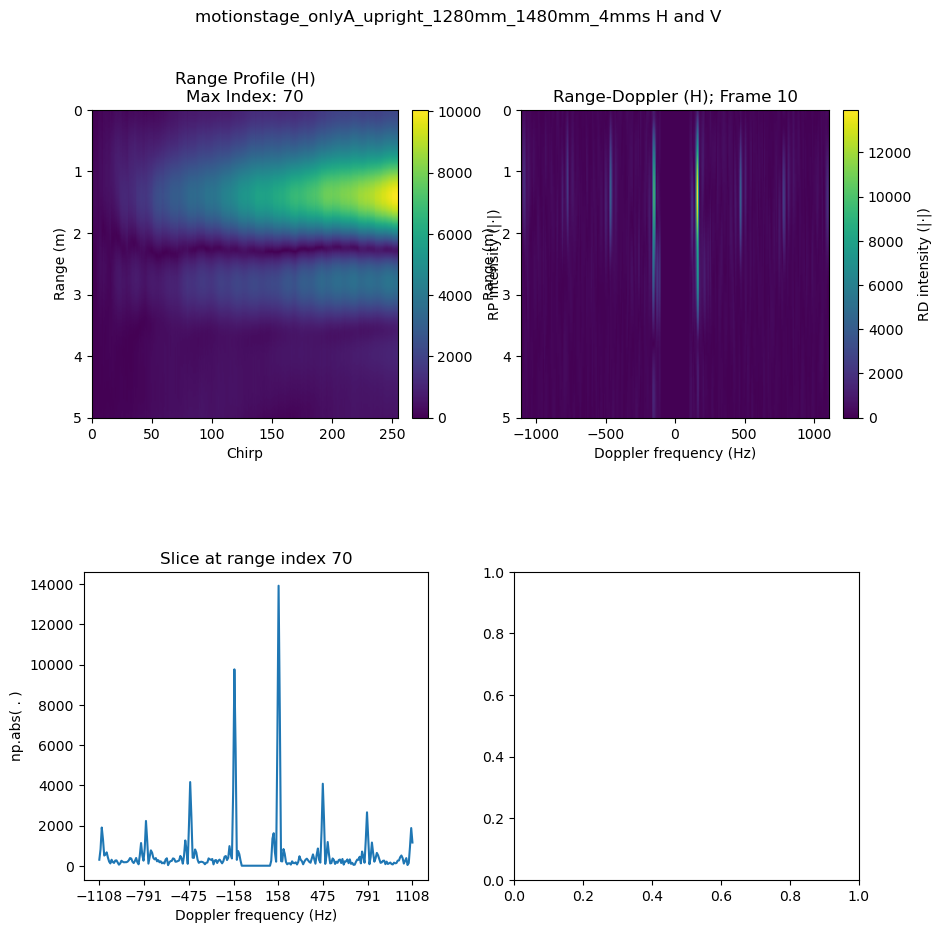

In [11]:
plot_rp_rd("motionstage_onlyA_upright_1280mm_1480mm_4mms", 10)

[-1090.66289062 -1056.03867187 -1021.41445312 -1004.10234375
  -986.79023437  -969.478125    -943.50996094  -917.54179687
  -891.57363281  -848.29335937  -813.66914062  -779.04492187
  -744.42070312  -727.10859375  -692.484375    -675.17226562
  -623.2359375   -588.61171875  -571.29960937  -536.67539062
  -502.05117187  -467.42695312  -432.80273437  -398.17851562
  -363.55429687  -320.27402344  -294.30585937  -259.68164062
  -225.05742187  -190.43320312  -155.80898437  -121.18476562
   121.18476562   155.80898437   190.43320312   225.05742187
   259.68164062   294.30585937   311.61796875   328.93007812
   346.2421875    372.21035156   398.17851562   432.80273437
   467.42695312   502.05117187   545.33144531   571.29960937
   588.61171875   623.2359375    657.86015625   683.82832031
   709.79648437   744.42070312   779.04492187   813.66914062
   848.29335937   882.91757812   926.19785156   952.16601562
   969.478125     986.79023437  1004.10234375  1021.41445312
  1038.7265625   1056.03

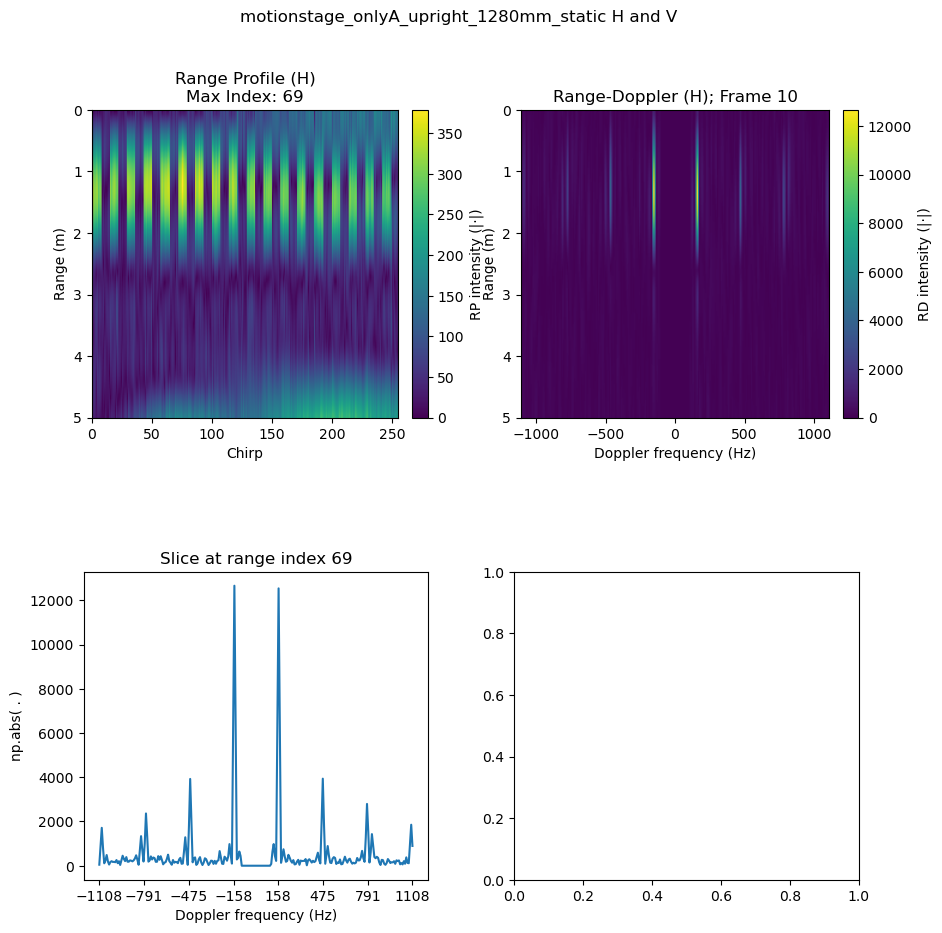

In [10]:
plot_rp_rd("motionstage_onlyA_upright_1280mm_static", 10)

[-1082.00683594 -1056.03867187 -1038.7265625  -1012.75839844
  -986.79023437  -943.50996094  -926.19785156  -874.26152344
  -856.94941406  -839.63730469  -787.70097656  -744.42070312
  -718.45253906  -683.82832031  -657.86015625  -631.89199219
  -553.9875      -536.67539062  -519.36328125  -502.05117187
  -476.08300781  -458.77089844  -415.490625    -398.17851562
  -380.86640625  -363.55429687  -320.27402344  -294.30585937
  -259.68164062  -242.36953125  -199.08925781  -181.77714844
  -164.46503906  -129.84082031  -112.52871094   129.84082031
   155.80898437   190.43320312   216.40136719   251.02558594
   294.30585937   320.27402344   337.58613281   363.55429687
   389.52246094   415.490625     450.11484375   493.39511719
   528.01933594   571.29960937   597.26777344   623.2359375
   666.51621094   692.484375     718.45253906   779.04492187
   830.98125      856.94941406   874.26152344   908.88574219
   943.50996094   986.79023437  1038.7265625   1064.69472656]


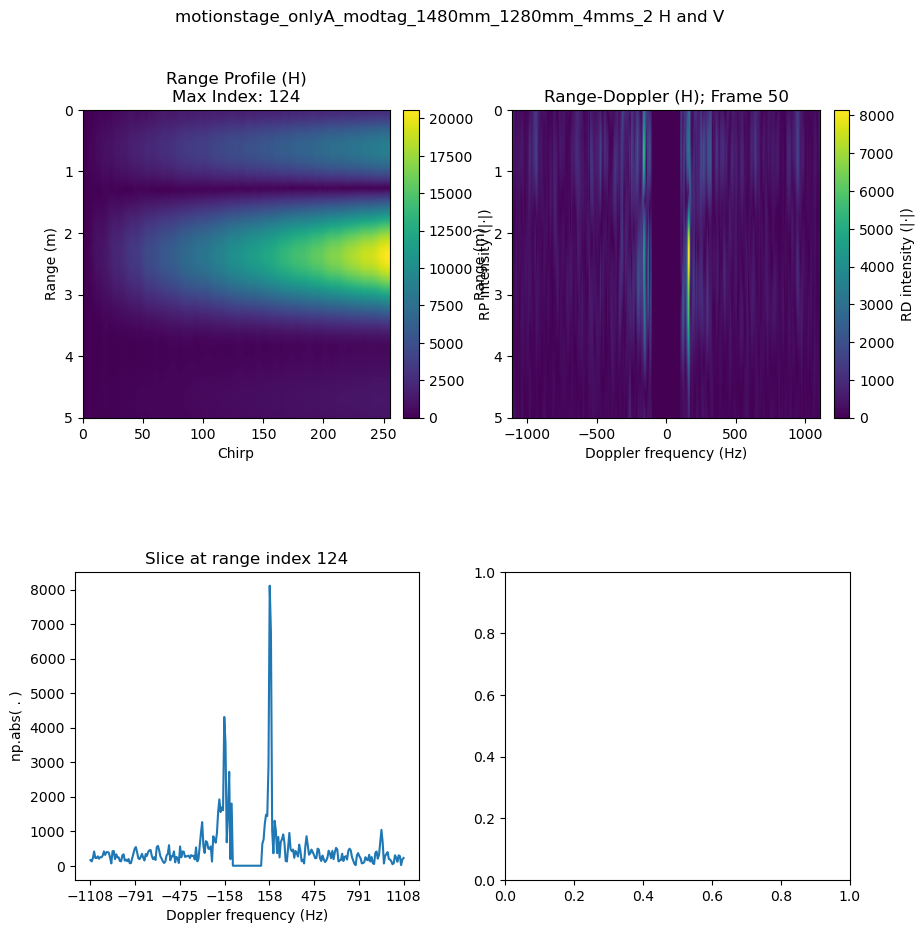

In [9]:
plot_rp_rd("motionstage_onlyA_modtag_1480mm_1280mm_4mms_2", 50)

[-1099.31894531 -1064.69472656 -1038.7265625  -1012.75839844
  -986.79023437  -952.16601562  -926.19785156  -900.2296875
  -874.26152344  -822.32519531  -796.35703125  -761.7328125
  -735.76464844  -683.82832031  -640.54804687  -614.57988281
  -579.95566406  -562.64355469  -519.36328125  -476.08300781
  -432.80273437  -389.52246094  -346.2421875   -311.61796875
  -285.64980469  -251.02558594  -225.05742187  -199.08925781
  -112.52871094   103.87265625   155.80898437   190.43320312
   207.7453125    251.02558594   268.33769531   285.64980469
   328.93007812   346.2421875    380.86640625   398.17851562
   441.45878906   467.42695312   502.05117187   545.33144531
   614.57988281   649.20410156   675.17226562   692.484375
   727.10859375   744.42070312   770.38886719   796.35703125
   822.32519531   848.29335937   882.91757812   926.19785156
   943.50996094   969.478125     986.79023437  1021.41445312
  1047.38261719  1073.35078125  1090.66289062]


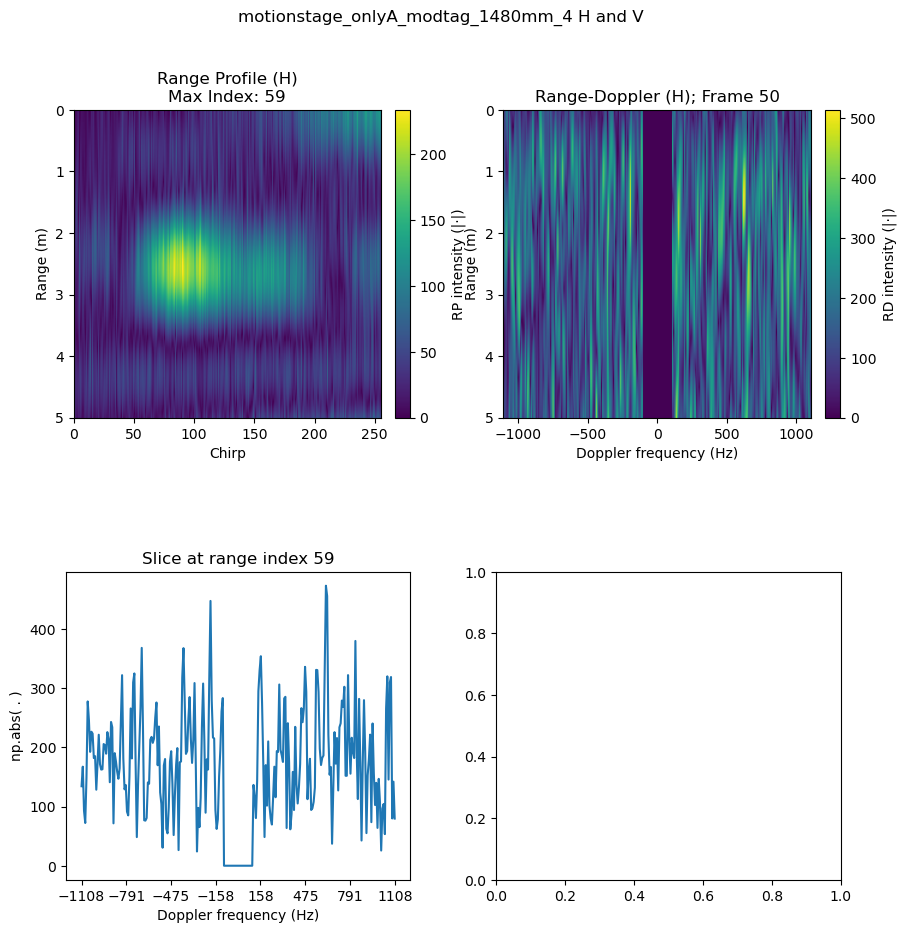

In [8]:
plot_rp_rd("motionstage_onlyA_modtag_1480mm_4", 50)

[-1099.31894531 -1073.35078125 -1038.7265625  -1021.41445312
  -995.44628906  -969.478125    -952.16601562  -934.85390625
  -908.88574219  -874.26152344  -830.98125     -813.66914062
  -787.70097656  -770.38886719  -753.07675781  -709.79648437
  -657.86015625  -614.57988281  -588.61171875  -562.64355469
  -510.70722656  -493.39511719  -467.42695312  -450.11484375
  -424.14667969  -380.86640625  -328.93007812  -302.96191406
  -259.68164062  -242.36953125  -207.7453125   -173.12109375
  -155.80898437  -138.496875    -112.52871094   103.87265625
   129.84082031   155.80898437   181.77714844   207.7453125
   242.36953125   268.33769531   285.64980469   320.27402344
   354.89824219   389.52246094   467.42695312   484.7390625
   519.36328125   553.9875       579.95566406   597.26777344
   614.57988281   649.20410156   666.51621094   692.484375
   718.45253906   735.76464844   753.07675781   779.04492187
   839.63730469   874.26152344   908.88574219   934.85390625
   960.82207031   986.790234

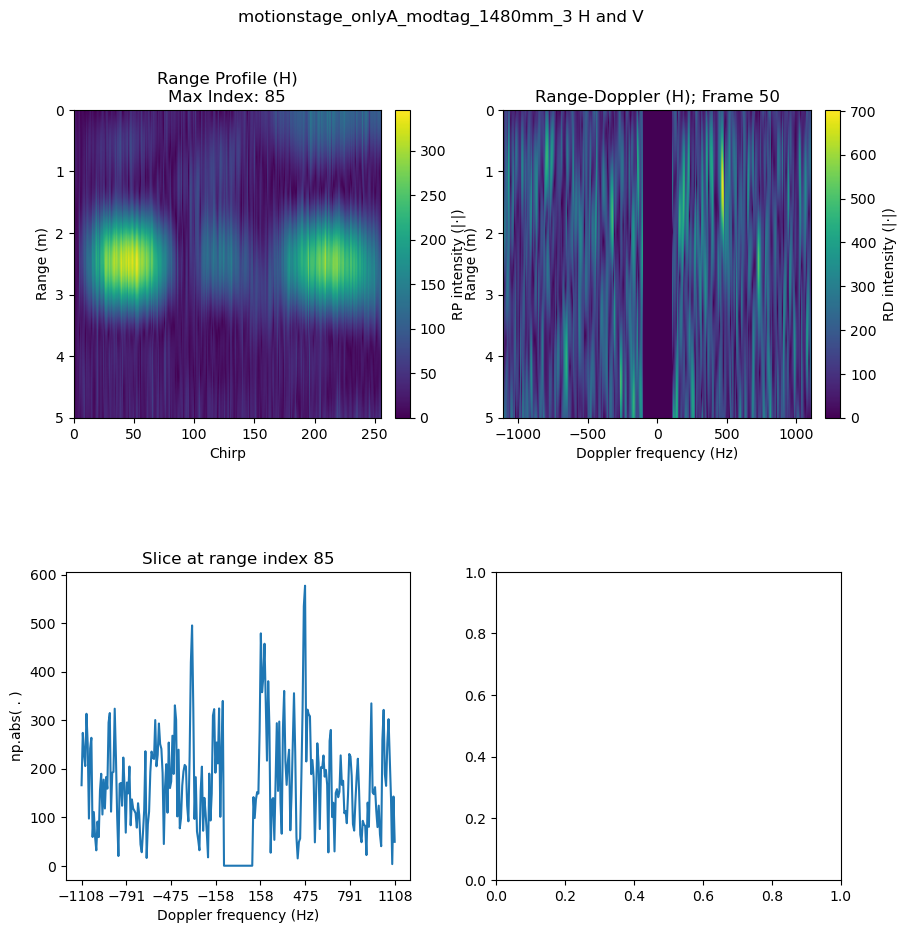

In [7]:
plot_rp_rd("motionstage_onlyA_modtag_1480mm_3", 50)

[-1073.35078125 -1021.41445312 -1004.10234375  -952.16601562
  -926.19785156  -891.57363281  -848.29335937  -822.32519531
  -805.01308594  -770.38886719  -744.42070312  -709.79648437
  -692.484375    -675.17226562  -657.86015625  -605.92382812
  -571.29960937  -545.33144531  -519.36328125  -467.42695312
  -415.490625    -389.52246094  -363.55429687  -337.58613281
  -311.61796875  -294.30585937  -259.68164062  -242.36953125
  -216.40136719  -199.08925781  -164.46503906  -112.52871094
   112.52871094   155.80898437   190.43320312   259.68164062
   311.61796875   346.2421875    363.55429687   389.52246094
   406.83457031   450.11484375   484.7390625    510.70722656
   545.33144531   588.61171875   623.2359375    657.86015625
   692.484375     727.10859375   753.07675781   779.04492187
   796.35703125   813.66914062   848.29335937   882.91757812
   908.88574219   952.16601562   978.13417969  1030.07050781
  1056.03867187  1090.66289062]


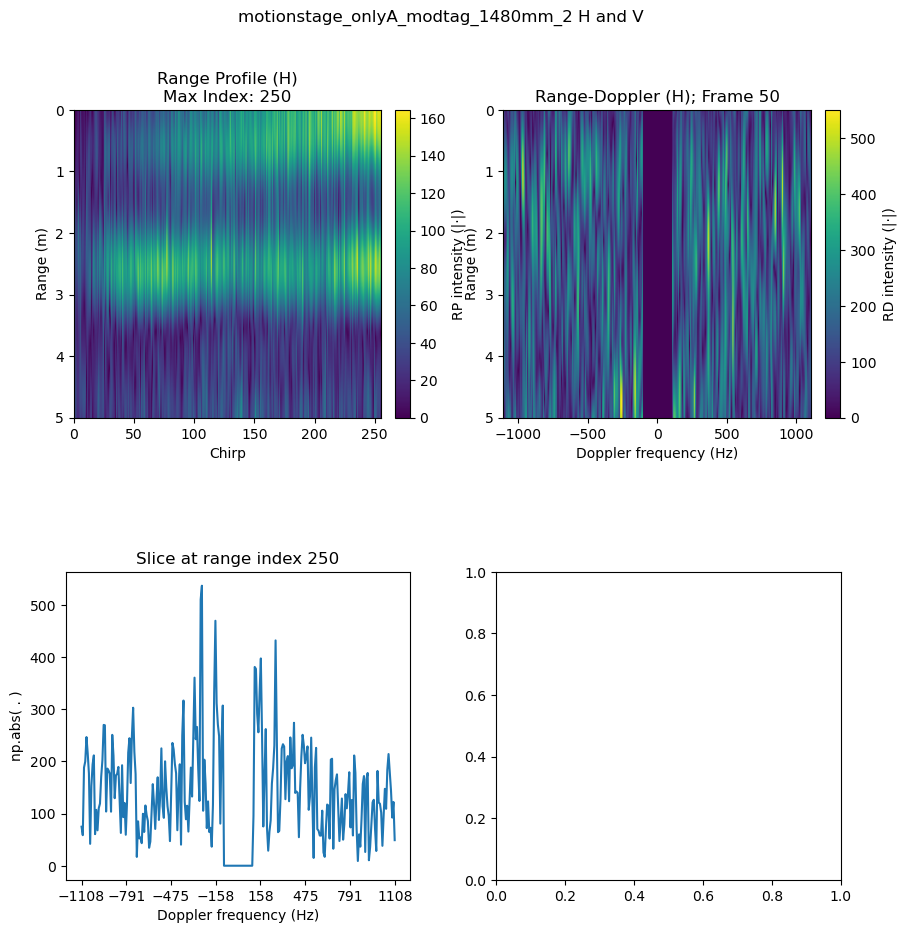

In [6]:
plot_rp_rd("motionstage_onlyA_modtag_1480mm_2", 50)

[-1099.31894531 -1073.35078125 -1047.38261719 -1030.07050781
  -995.44628906  -943.50996094  -926.19785156  -874.26152344
  -848.29335937  -805.01308594  -761.7328125   -727.10859375
  -701.14042969  -683.82832031  -657.86015625  -631.89199219
  -605.92382812  -588.61171875  -571.29960937  -545.33144531
  -519.36328125  -484.7390625   -450.11484375  -415.490625
  -389.52246094  -337.58613281  -302.96191406  -285.64980469
  -251.02558594  -225.05742187  -207.7453125   -155.80898437
  -121.18476562   112.52871094   155.80898437   225.05742187
   251.02558594   276.99375      302.96191406   328.93007812
   346.2421875    363.55429687   389.52246094   415.490625
   441.45878906   458.77089844   476.08300781   493.39511719
   510.70722656   553.9875       579.95566406   605.92382812
   631.89199219   666.51621094   683.82832031   701.14042969
   735.76464844   787.70097656   813.66914062   848.29335937
   891.57363281   952.16601562  1004.10234375  1030.07050781
  1064.69472656  1090.662890

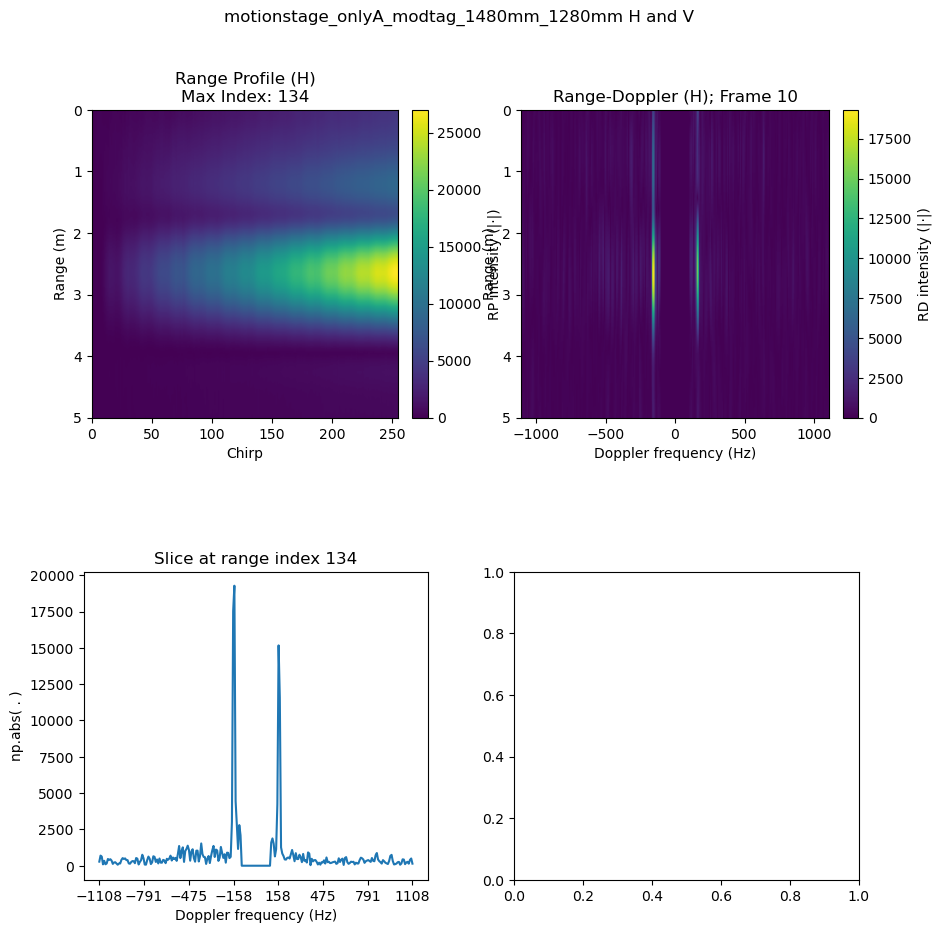

In [6]:
plot_rp_rd("motionstage_onlyA_modtag_1480mm_1280mm", 10)

[-1099.31894531 -1082.00683594 -1047.38261719 -1030.07050781
 -1004.10234375  -978.13417969  -917.54179687  -900.2296875
  -874.26152344  -830.98125     -805.01308594  -779.04492187
  -761.7328125   -727.10859375  -692.484375    -666.51621094
  -623.2359375   -588.61171875  -536.67539062  -519.36328125
  -502.05117187  -484.7390625   -458.77089844  -424.14667969
  -380.86640625  -346.2421875   -320.27402344  -302.96191406
  -259.68164062  -207.7453125   -155.80898437  -121.18476562
   112.52871094   155.80898437   190.43320312   225.05742187
   268.33769531   285.64980469   320.27402344   363.55429687
   398.17851562   450.11484375   502.05117187   528.01933594
   562.64355469   579.95566406   614.57988281   640.54804687
   657.86015625   683.82832031   727.10859375   744.42070312
   770.38886719   796.35703125   822.32519531   839.63730469
   891.57363281   952.16601562   986.79023437  1021.41445312
  1047.38261719  1082.00683594]


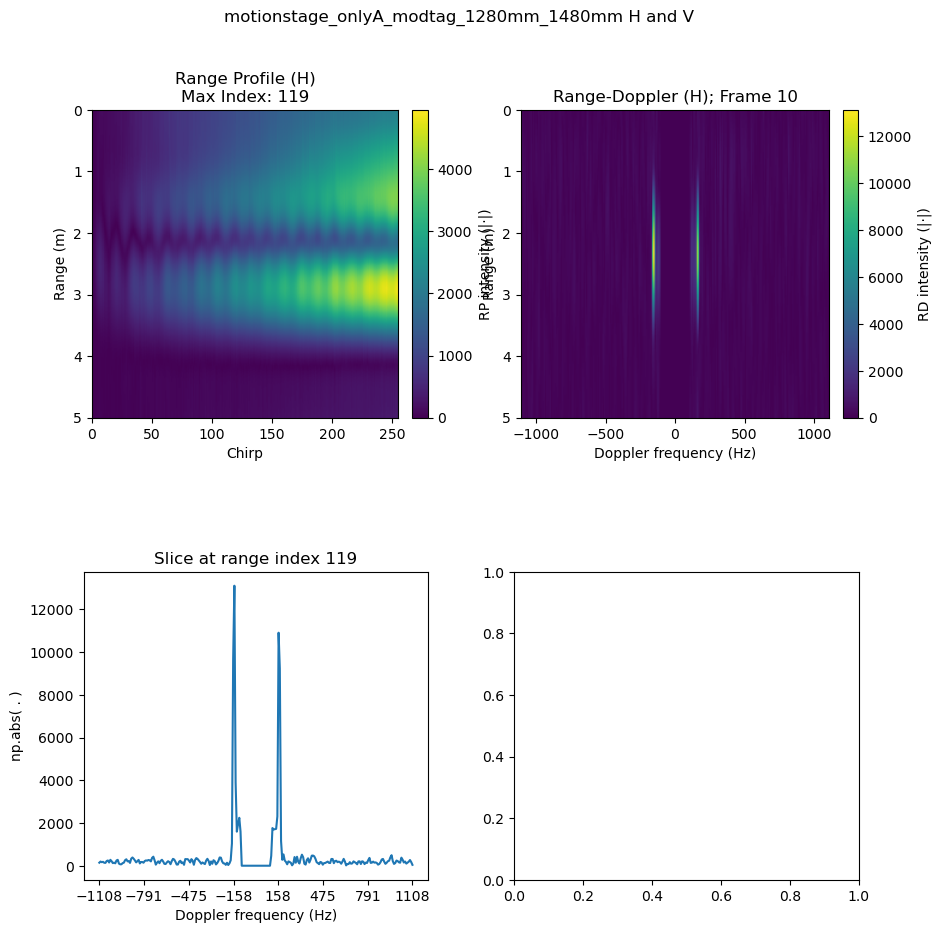

In [7]:
plot_rp_rd("motionstage_onlyA_modtag_1280mm_1480mm", 10)

[-1082.00683594 -1056.03867187 -1038.7265625  -1012.75839844
  -986.79023437  -969.478125    -926.19785156  -900.2296875
  -856.94941406  -830.98125     -787.70097656  -753.07675781
  -727.10859375  -692.484375    -657.86015625  -640.54804687
  -623.2359375   -597.26777344  -579.95566406  -562.64355469
  -536.67539062  -502.05117187  -476.08300781  -458.77089844
  -415.490625    -398.17851562  -372.21035156  -354.89824219
  -328.93007812  -311.61796875  -268.33769531  -242.36953125
  -207.7453125   -190.43320312  -155.80898437  -121.18476562
   112.52871094   155.80898437   225.05742187   251.02558594
   285.64980469   311.61796875   337.58613281   363.55429687
   380.86640625   424.14667969   476.08300781   510.70722656
   528.01933594   553.9875       571.29960937   623.2359375
   666.51621094   692.484375     727.10859375   753.07675781
   779.04492187   805.01308594   830.98125      900.2296875
   943.50996094   978.13417969  1030.07050781  1056.03867187
  1082.00683594]


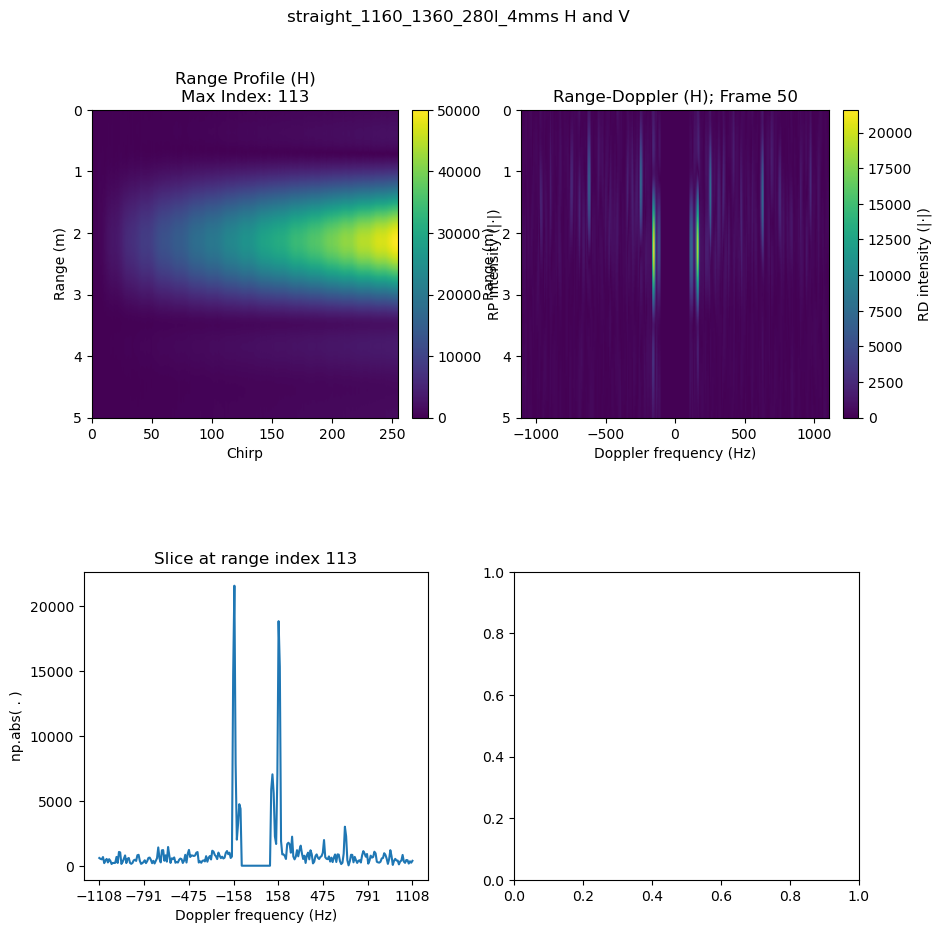

In [5]:
plot_rp_rd("straight_1160_1360_280l_4mms", 50)

[-1064.69472656 -1038.7265625  -1021.41445312  -969.478125
  -926.19785156  -900.2296875   -882.91757812  -856.94941406
  -830.98125     -761.7328125   -727.10859375  -692.484375
  -657.86015625  -631.89199219  -553.9875      -519.36328125
  -484.7390625   -458.77089844  -441.45878906  -415.490625
  -380.86640625  -346.2421875   -311.61796875  -285.64980469
  -251.02558594  -225.05742187  -199.08925781  -181.77714844
  -155.80898437  -121.18476562   103.87265625   138.496875
   155.80898437   199.08925781   225.05742187   251.02558594
   276.99375      311.61796875   346.2421875    372.21035156
   415.490625     441.45878906   458.77089844   476.08300781
   502.05117187   528.01933594   553.9875       588.61171875
   623.2359375    657.86015625   675.17226562   692.484375
   735.76464844   753.07675781   770.38886719   796.35703125
   830.98125      865.60546875   882.91757812   900.2296875
   943.50996094   969.478125    1038.7265625   1056.03867187]


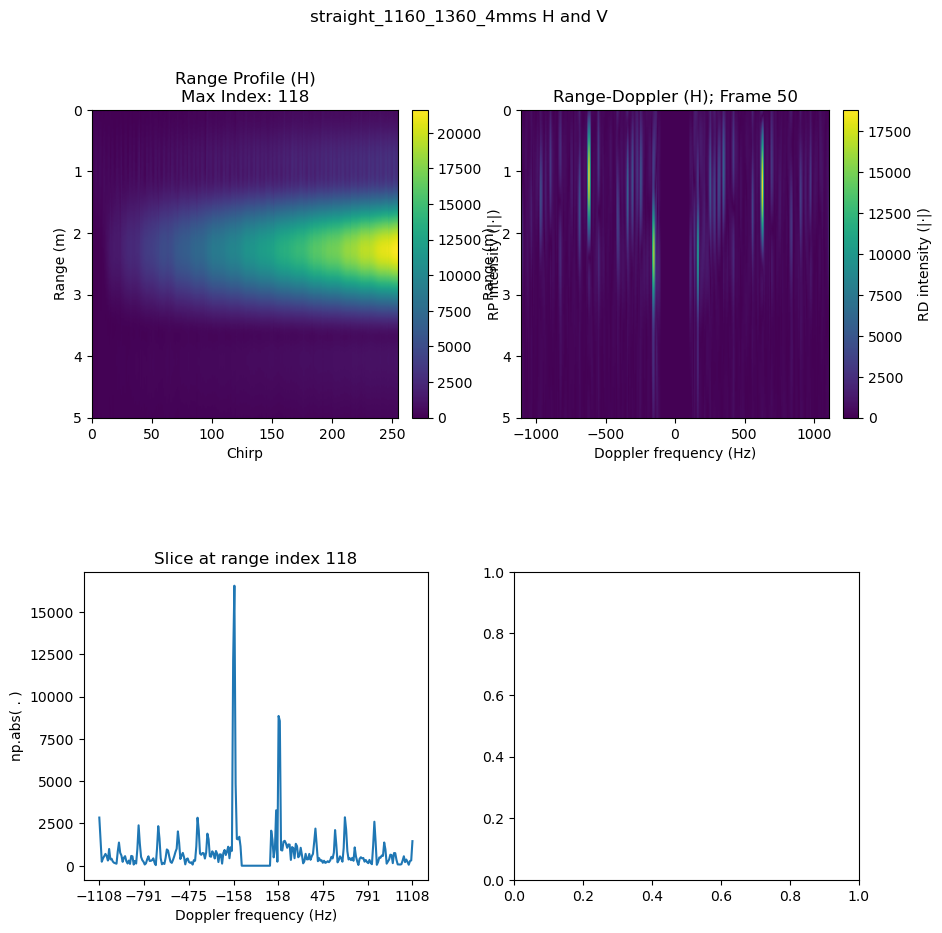

In [6]:
plot_rp_rd('straight_1160_1360_4mms', 50)